<a href="https://colab.research.google.com/github/arthurflor/courses/blob/master/google-machine-learning-crash-course/16_google_play_store_(ratings).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Play Store (Ratings)

In [27]:
from tensorflow.python.data import Dataset
from IPython import display
from sklearn import metrics
from matplotlib import pyplot as plt

import tensorflow as tf
import pandas as pd
import numpy as np

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

googleplaystore_dataframe = pd.read_csv("https://raw.githubusercontent.com/arthurflor/courses/master/google-machine-learning-crash-course/googleplaystore_pre_process.csv", sep=",")
googleplaystore_dataframe = googleplaystore_dataframe.reindex(np.random.permutation(googleplaystore_dataframe.index))
googleplaystore_dataframe

,app,category,rating,review,size,install,type,price,content_rating,genre,last_uptaded,current_ver,android_ver
3746,The Guardian,NEWS_AND_MAGAZINES,4.7,247992,22.0,5000000,0,0.0,Teen,News & Magazines,"July 25, 2018",6.5.1725,4.1
5040,50000 Free eBooks & Free AudioBooks,BOOKS_AND_REFERENCE,4.1,52312,11.0,5000000,0,0.0,Teen,Books & Reference,"May 19, 2018",5.3.4,4.4
7146,US 115th CD,TRAVEL_AND_LOCAL,0.0,0,5.7,5,0,0.0,Everyone,Travel & Local,"November 3, 2017",106,4.0.3
4102,F-Sim Space Shuttle,FAMILY,4.4,5427,0.0,100,1,5.0,Everyone,Simulation,"January 28, 2014",0.0,0.0
6201,Discípulos em BH,SOCIAL,0.0,24,5.2,100,0,0.0,Everyone,Social,"February 24, 2018",1.1.4,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10317,Curso Básico y Avanzado la Fe de Jesús Audio-T...,FAMILY,0.0,0,11.0,10,0,0.0,Everyone,Education,"July 12, 2018",1.0,4.0
9145,EB-TV,SPORTS,0.0,6,30.0,1,0,0.0,Everyone,Sports,"May 25, 2018",2.2.1,4.4
7777,CS Customizer,COMMUNICATION,3.7,25,3.7,1,0,0.0,Everyone,Communication,"February 6, 2017",1.2.11,3.0
10529,FL State Parks Guide,TRAVEL_AND_LOCAL,3.7,871,45.0,100,0,0.0,Everyone,Travel & Local,"October 27, 2017",5.29.23,4.4


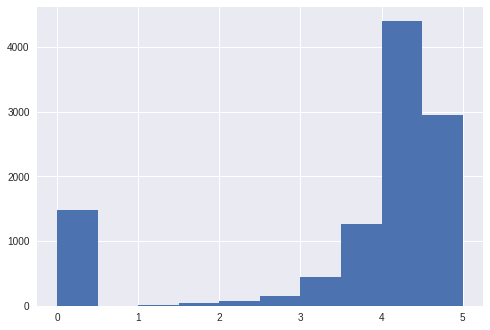

In [28]:
#googleplaystore_dataframe["rating"] = googleplaystore_dataframe["rating"].apply(lambda x: max(x, 3.2))
googleplaystore_dataframe["rating"].hist()

In [0]:
def preprocess_features(googleplaystore_dataframe):
  """Preparar inputs do dataset googleplaystore.

  Args:
    googleplaystore_dataframe: Pandas DataFrame (dataset).

  Returns:
    DataFrame contendo os inputs necessários.
  """

  selected_features = googleplaystore_dataframe[[
      "category",
      "review",
      "size",
      "install",
      "type",
      "price",
      "content_rating",
      "genre",
      "android_ver",
   ]]

  processed_features = selected_features.copy()
  
  # Criando grupos (códigos) para as categorias
  processed_features["category"] = pd.Categorical(processed_features["category"]).codes
  processed_features["content_rating"] = pd.Categorical(processed_features["content_rating"]).codes
  processed_features["genre"] = pd.Categorical(processed_features["genre"]).codes
  processed_features["android_ver"] = pd.Categorical(processed_features["android_ver"]).codes
  
  # Criando atributo sintético.
#   processed_features["rating_per_install"] = (googleplaystore_dataframe["rating"] * googleplaystore_dataframe["install"])
  processed_features["install_sub_review"] = (googleplaystore_dataframe["install"] - googleplaystore_dataframe["review"])
  
  return processed_features

def preprocess_targets(googleplaystore_dataframe):
  """Preparar targets do dataset googleplaystore.

  Args:
    googleplaystore_dataframe: Pandas DataFrame (dataset).

  Returns:
    DataFrame contendo os targets.
  """
  
  output_targets = pd.DataFrame()
  
  # Criando valor booleano representando um "app de sucesso".
  norm_rating = (googleplaystore_dataframe["rating"] * (googleplaystore_dataframe["install"]/100))r
  
  output_targets["app_success"] = (norm_rating > 4).astype(float)
    
  return output_targets

In [40]:
length = len(googleplaystore_dataframe)
training_len = int(length * 0.8)
validation_len = int(length * 0.2)

training_examples = preprocess_features(googleplaystore_dataframe.head(training_len))
training_targets = preprocess_targets(googleplaystore_dataframe.head(training_len))

validation_examples = preprocess_features(googleplaystore_dataframe.tail(validation_len))
validation_targets = preprocess_targets(googleplaystore_dataframe.tail(validation_len))

print("Resumo dos dados de treino (inputs):")
display.display(training_examples.describe())

print("Resumo dos dados de treino (targets):")
display.display(training_targets.describe())


print("Resumo dos dados de validação (inputs):")
display.display(validation_examples.describe())

print("Resumo dos dados de validação (targets):")
display.display(validation_targets.describe())

Resumo dos dados de treino (inputs):


,category,review,size,install,type,price,content_rating,genre,android_ver,install_sub_review
count,8640.0,8640.0,8640.0,8640.0,8640.0,8640.0,8640.0,8640.0,8640.0,8640.0
mean,16.8,436824.7,31.6,15792423.0,0.1,1.0,1.3,60.6,13.5,15355598.3
std,8.3,2900940.8,94.1,85777241.9,0.3,15.5,0.6,30.9,6.6,83942427.4
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-83614.0
25%,11.0,38.0,3.1,10.0,0.0,0.0,1.0,36.0,10.0,-137.2
50%,14.0,2145.0,10.0,100.0,0.0,0.0,1.0,63.0,15.0,87.0
75%,25.0,57947.0,28.0,5000000.0,0.0,0.0,1.0,86.0,17.0,4849742.2
max,32.0,78158306.0,1020.0,1000000000.0,1.0,400.0,4.0,112.0,31.0,999122365.0


Resumo dos dados de treino (targets):


,app_success
count,8640.0
mean,0.6
std,0.5
min,0.0
25%,0.0
50%,1.0
75%,1.0
max,1.0


Resumo dos dados de validação (inputs):


,category,review,size,install,type,price,content_rating,genre,android_ver,install_sub_review
count,2160.0,2160.0,2160.0,2160.0,2160.0,2160.0,2160.0,2160.0,2160.0,2160.0
mean,16.7,481414.8,29.9,14211638.3,0.1,1.0,0.3,49.6,10.8,13730223.5
std,8.4,3058599.5,83.0,82797795.4,0.3,15.4,0.7,25.4,5.4,80851397.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-167474.0
25%,11.0,35.0,3.2,10.0,0.0,0.0,0.0,29.0,8.0,-167.5
50%,14.0,1972.5,10.0,100.0,0.0,0.0,0.0,53.0,12.0,50.0
75%,24.2,45776.5,29.0,1000000.0,0.0,0.0,0.0,73.0,13.0,998093.8
max,32.0,69119316.0,957.0,1000000000.0,1.0,400.0,2.0,88.0,22.0,997271059.0


Resumo dos dados de validação (targets):


,app_success
count,2160.0
mean,0.6
std,0.5
min,0.0
25%,0.0
50%,1.0
75%,1.0
max,1.0


In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Organizar dados para treinamento.
  
    Args:
      features: pandas DataFrame (inputs)
      targets: pandas DataFrame (targets)
      batch_size: tamanho do batch para o treinamento
      shuffle: Embaralhar os dados.
      num_epochs: Número de épocas. None=indefinido
    
    Returns:
      Tupla de atributos e targets.
    """
    
    features = {index:np.array(item) for (index, item) in dict(features).items()}                                            
 
    ds = Dataset.from_tensor_slices((features, targets)) # limite de 2GB
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
      ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    
    return features, labels

In [0]:
def train_linear_classifier_model(learning_rate, steps, batch_size, training_examples, training_targets, validation_examples, validation_targets):
  """Treinar modelo. Mostrar progresso de treinamento e resultados.
    
  Args:
    learning_rate: taxa de aprendizagem (float).
    steps: número de etapas do treinamento (int > 0). Consiste em uma passagem de "ida e volta" de um batch.
    batch_size: tamanho de um batch (int > 0).
    training_examples: Pandas DataFrame contendo uma ou mais colunas do dataset como atributos de input para o treinamento.
    training_targets: Pandas DataFrame contendo uma coluna com os targets (labels) para o treinamento.
    validation_examples: Pandas DataFrame contendo uma ou mais colunas do dataset como atributos de input para a validação.
    validation_targets: Pandas DataFrame contendo uma coluna com os targets (labels) para a validação.

  Returns:
    Objeto `LinearClassifier' treinado.
  """

  periods = 10
  steps_per_period = steps/periods
    
  # lambda para auxiliar na construção dos atributos em colunas para o TensorFlow
  construct_feature_columns = lambda input_features: set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])
  
  # otimizador
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  
  # classificador linear
  linear_classifier = tf.estimator.LinearClassifier(feature_columns=construct_feature_columns(training_examples), optimizer=my_optimizer)
  
  # lambdas para a organização dos inputs
  training_input_fn = lambda: my_input_fn(training_examples, training_targets["app_success"], batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["app_success"], num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["app_success"], num_epochs=1, shuffle=False)
  
  print("Treinando...")  
  training_log_losses = []
  validation_log_losses = []
  
  for period in range(0, periods):
    # treinamento `training_input_fn`
    linear_classifier.train(input_fn=training_input_fn, steps=steps_per_period)
    
    # calcular previsões `predict_training_input_fn` (treinamento)
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    # calcular previsões `predict_validation_input_fn` (validação)
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    # calculando log_loss do treinamento e validação
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    
    print("period %s | loss %0.4f | val_loss %0.4f" % ((period+1), training_log_loss, validation_log_loss))
    
    # adicionar as métricas desse período nas listas
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)

  print("Treinamento finalizado.\n")
  
  # calculando acurácia e plotando curva ROC dos dados de validação
  evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)
  
  # calculando previsões `predict_validation_input_fn` (validação)
  validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
  
  # probabilidade (verdadeiro positivo e falso positivo)
  validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])
  false_positive_rate, true_positive_rate, _ = metrics.roc_curve(validation_targets, validation_probabilities)
  
  print("AUC nos dados de validação: %0.4f" % evaluation_metrics['auc'])
  print("Acurácia nos dados de validação: %0.4f\n" % evaluation_metrics['accuracy'])

  plt.figure(0)
  plt.title("AUC")
  plt.plot(false_positive_rate, true_positive_rate, label="our model")
  plt.plot([0, 1], [0, 1], label="random classifier")
  plt.legend()
  
  # plot de gráfico da métrica: log_loss vs períodos.
  plt.figure(1)
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()
  
  return linear_classifier

Treinando...
period 1 | loss 0.3431 | val_loss 0.3438
period 2 | loss 0.3066 | val_loss 0.3102
period 3 | loss 0.2840 | val_loss 0.2884
period 4 | loss 0.2706 | val_loss 0.2745
period 5 | loss 0.2592 | val_loss 0.2629
period 6 | loss 0.2530 | val_loss 0.2551
period 7 | loss 0.2480 | val_loss 0.2501
period 8 | loss 0.2447 | val_loss 0.2456
period 9 | loss 0.2422 | val_loss 0.2426
period 10 | loss 0.2407 | val_loss 0.2400
Treinamento finalizado.

AUC nos dados de validação: 0.9633
Acurácia nos dados de validação: 0.9144



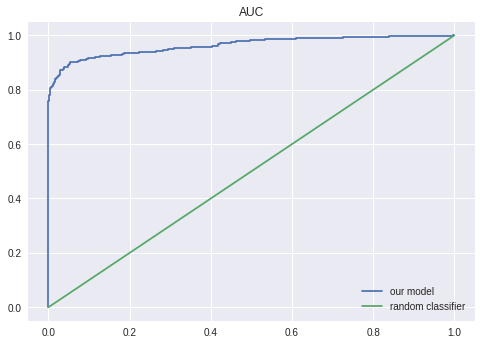

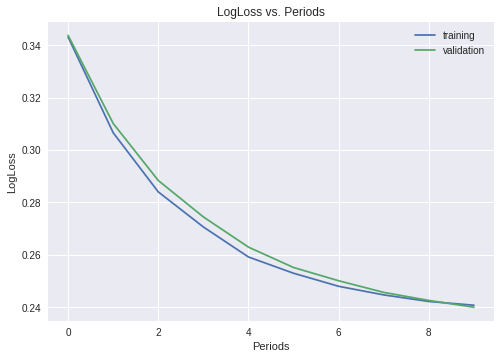

In [44]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000003,
    steps=10000,
    batch_size=500,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)